In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
"""
Fantasy Rules:

1 Point (2*(FG-3P) + 3*(3P) + FT) = 0.5 fpts
1 Rebound (TRB) = 1 fpts
1 Assist (AST) = 1 fpts
1 Steal (STL) = 2 fpts
1 Block (BLK) = 2 fpts
1 Turnover (TOV) = -1 fpts

Extra 0.5 fpts for every 3 Pointer (3P)
Extra 1 fpts for a double double
Extra 2 fpts for a triple double (3, since a triple double is also a double double)
"""

In [3]:
df = pd.read_csv('/Users/maxmandel/Downloads/wemby_2425_stats.csv')
df

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1.0,10/24/24,20-294,SAS,@,DAL,L (-11),1,28:28:00,...,7.0,9.0,1.0,0.0,1.0,4.0,1.0,17.0,6.9,-20.0
1,2,2.0,10/26/24,20-296,SAS,NaN,HOU,W (+3),1,30:12:00,...,6.0,7.0,1.0,0.0,3.0,3.0,3.0,29.0,21.8,0.0
2,3,3.0,10/28/24,20-298,SAS,NaN,HOU,L (-5),1,35:13:00,...,15.0,20.0,5.0,0.0,4.0,4.0,3.0,14.0,15.3,-7.0
3,4,4.0,10/30/24,20-300,SAS,@,OKC,L (-12),1,27:15:00,...,7.0,8.0,2.0,0.0,3.0,4.0,0.0,6.0,5.2,-4.0
4,5,5.0,10/31/24,20-301,SAS,@,UTA,W (+18),1,33:33:00,...,7.0,9.0,7.0,5.0,5.0,3.0,3.0,25.0,27.3,43.0
5,6,6.0,11/2/24,20-303,SAS,NaN,MIN,W (+10),1,30:59:00,...,5.0,6.0,3.0,1.0,2.0,3.0,4.0,17.0,11.4,13.0
6,7,7.0,11/4/24,20-305,SAS,@,LAC,L (-9),1,34:06:00,...,11.0,13.0,3.0,3.0,9.0,2.0,3.0,24.0,25.1,-21.0
7,8,8.0,11/6/24,20-307,SAS,@,HOU,L (-27),1,24:41:00,...,5.0,6.0,0.0,1.0,3.0,4.0,0.0,15.0,8.9,-18.0
8,9,9.0,11/7/24,20-308,SAS,NaN,POR,W (+13),1,32:21:00,...,6.0,8.0,2.0,4.0,3.0,4.0,0.0,12.0,10.8,-7.0
9,10,10.0,11/9/24,20-310,SAS,NaN,UTA,L (-1),1,32:41:00,...,13.0,16.0,0.0,0.0,7.0,6.0,3.0,24.0,20.4,4.0


In [5]:
def calculate_fpts(row):
    
    pts = 2*(row['FG'] - row['3P']) + 3*row['3P'] + row['FT']
    rebs = row['TRB']
    asts = row['AST']
    stls = row['STL']
    blks = row['BLK']
    tovs = row['TOV']

    fpts = (0.5*pts) + 2*(stls + blks) + (rebs + asts) - tovs + 0.5*(row['3P'])

    stats = [pts, rebs, asts, stls, blks]
    count_doubles = 0
    for stat in stats:
        if stat >= 10:
            count_doubles += 1

    if count_doubles > 1:
        fpts += 1 # double double
    if count_doubles > 2:
        fpts += 2 # triple double

    return fpts

In [7]:
new_df = pd.DataFrame(columns=["DATE", "FPTS"])

for index, row in df.iterrows():

    game_date = row['Date']

    fpts = calculate_fpts(row)
    
    new_df.loc[len(new_df)] = [game_date, fpts]

new_df['DATE'] = pd.to_datetime(new_df['DATE'], format="%m/%d/%y")

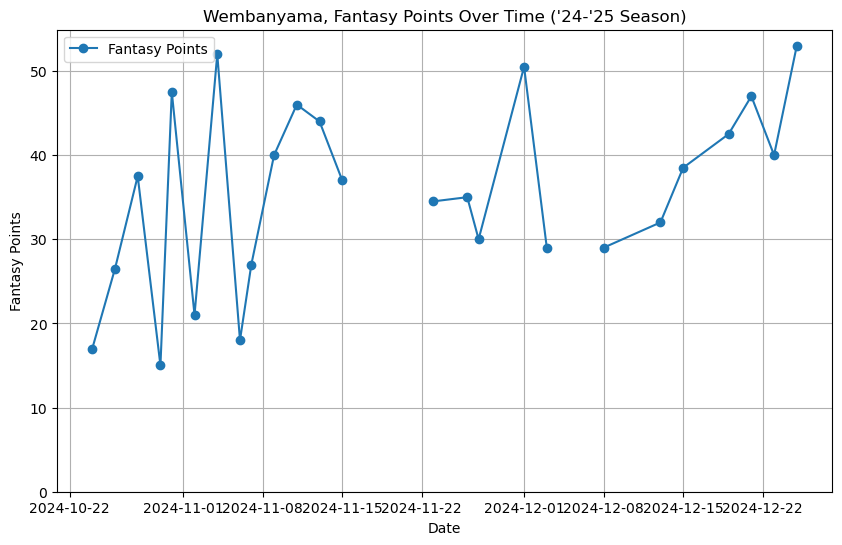

In [9]:
new_df.set_index("DATE", inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(new_df.index, new_df["FPTS"], marker='o', label='Fantasy Points')
plt.title("Wembanyama, Fantasy Points Over Time ('24-'25 Season)")
plt.xlabel("Date")
plt.ylabel("Fantasy Points")
plt.ylim(bottom=0)
plt.grid(True)
plt.legend()
plt.show()

In [11]:
df_vw = pd.read_csv('/Users/maxmandel/Downloads/wemby_2425_stats.csv')
df_ae = pd.read_csv('/Users/maxmandel/Downloads/antedwards_2425_stats.csv')
df_ki = pd.read_csv('/Users/maxmandel/Downloads/kyrieirving_2425_stats.csv')
df_lb = pd.read_csv('/Users/maxmandel/Downloads/lameloball_2425_stats.csv')
df_jb = pd.read_csv('/Users/maxmandel/Downloads/jaylenbrown_2425_stats.csv')
df_lj = pd.read_csv('/Users/maxmandel/Downloads/lebron_2425_stats.csv')
df_jb = pd.read_csv('/Users/maxmandel/Downloads/jimmybutler_2425_stats.csv')
df_df = pd.read_csv('/Users/maxmandel/Downloads/fox_2425_stats.csv')
df_kp = pd.read_csv('/Users/maxmandel/Downloads/porzingis_2425_stats.csv')
df_ty = pd.read_csv('/Users/maxmandel/Downloads/traeyoung_2425_stats.csv')
df_dm = pd.read_csv('/Users/maxmandel/Downloads/dmitch_2425_stats.csv')
df_iz = pd.read_csv('/Users/maxmandel/Downloads/zubac_2425_stats.csv')
df_nv = pd.read_csv('/Users/maxmandel/Downloads/vuc_2425_stats.csv')

player_data = {}
player_data['Victor Wembanyama'] = df_vw
player_data['Anthony Edwards'] = df_ae
player_data['Kyrie Irving'] = df_ki
player_data['Lamelo Ball'] = df_lb
player_data['Jaylen Brown'] = df_jb
player_data['Lebron James'] = df_lj
player_data['Jimmy Butler'] = df_jb
player_data["De'Aaron Fox"] = df_df
player_data['Kristaps Porzingis'] = df_kp
player_data['Trae Young'] = df_ty
player_data['Donovan Mitchell'] = df_dm
player_data['Ivica Zubac'] = df_iz

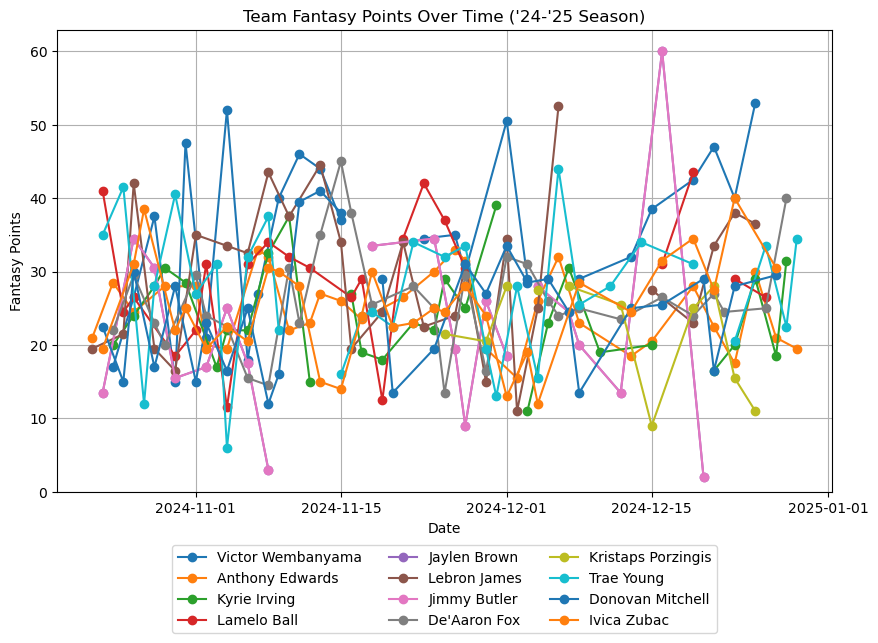

In [13]:
plt.figure(figsize=(10, 6))

all_fpts = []

for player, df in player_data.items():
    
    new_df = pd.DataFrame(columns=["DATE", "FPTS"])
    for index, row in df.iterrows():
        
        game_date = row['Date']
        fpts = calculate_fpts(row)
        if (fpts == fpts): # exclude NaN vals
            all_fpts.append(fpts)
        new_df.loc[len(new_df)] = [game_date, fpts]

    new_df['DATE'] = pd.to_datetime(new_df['DATE'], format="%m/%d/%y")

    new_df.set_index("DATE", inplace=True)
    plt.plot(new_df.index, new_df["FPTS"], marker='o', label=player)
    
plt.title("Team Fantasy Points Over Time ('24-'25 Season)")
plt.xlabel("Date")
plt.ylabel("Fantasy Points")
plt.ylim(bottom=0)
plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/kz/6mz46sg53gjcz39spsw6v7n80000gn/T/ipykernel_81606/3112944966.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, pdf_scaled, label=f"Normal Distribution\n($\mu={mu:.2f}$, $\sigma={sigma:.2f}$)", color="red")
/var/folders/kz/6mz46sg53gjcz39spsw6v7n80000gn/T/ipykernel_81606/3112944966.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, pdf_scaled, label=f"Normal Distribution\n($\mu={mu:.2f}$, $\sigma={sigma:.2f}$)", color="red")


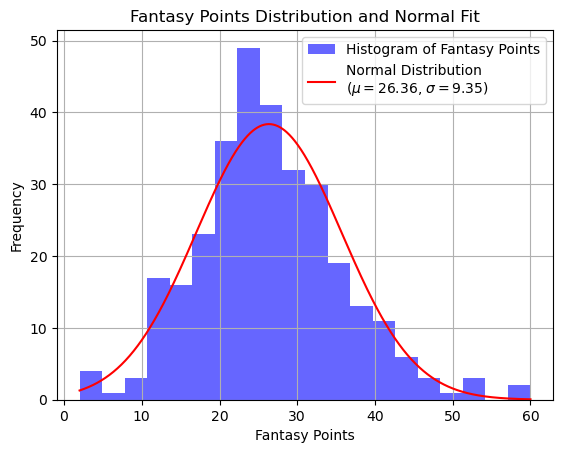

In [15]:
counts, bins, _ = plt.hist(all_fpts, bins=20, alpha=0.6, color='blue', label="Histogram of Fantasy Points")

mu = np.mean(all_fpts)
sigma = np.std(all_fpts)

x = np.linspace(min(bins), max(bins), 1000)

bin_width = bins[1] - bins[0]
pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
pdf_scaled = pdf * len(all_fpts) * bin_width

plt.plot(x, pdf_scaled, label=f"Normal Distribution\n($\mu={mu:.2f}$, $\sigma={sigma:.2f}$)", color="red")

plt.title("Fantasy Points Distribution and Normal Fit")
plt.xlabel("Fantasy Points")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()
